# Treble in the Sheets Semantic Segmentaion
In this part, you will design and implement your Convolutional Neural Networks to perform semantic segmentation on the Microsoft Research in Cambridge (MSRC) image understanding v2 dataset.

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) David FOUHEY, #12345678

## Setup
First, we will install some required packages for this notebook and download the MSRC-v2 Image dataset. 


In [1]:
# install required packages and download the dataset
# Run the command in the terminal if it failed on local Jupyter Notebook, remove "!" before each line
!pip install colormap easydev pypng torchsummary

In [2]:
import os
import time
import json
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import png
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from PIL import Image
import torchvision
from colormap.colors import Color, hex2rgb
from sklearn.metrics import average_precision_score as ap_score
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
from tqdm import tqdm

In [3]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = 'cuda'
else:
    print("Using the CPU. Overall speed will be slowed down")
    device = 'cpu'

Using the CPU. Overall speed will be slowed down


## Dataset
We will create a custom Dataset function for the MSRC-v2 dataset. You don't have to change anything here.

In [4]:
N_CLASS = 13

class DeepScoresDataset(Dataset):
    def __init__(self, split, 
                 split_path="ds2_dense/split.json",
                 one_hot=False):
        super().__init__()
        self.one_hot = one_hot
        img_folder = 'ds2_dense/Images'
        mask_folder = 'ds2_dense/GroundTruth'
        GTQ_folder = 'ds2_dense/GT_Quantize'
        
        self.dataset = json.load(open(split_path, 'r'))[split]
        
        self.group2label_idx = {'void': 0, 'lineNote': 1, 'quarterRest': 2, 'clef': 3, 'middleNote': 4, 'stem': 5, 'bars': 6, 'middleWholes': 7, 'lineWholes': 8, 'middleHalves': 9, 'lineHalves': 10, 'sharps': 11, 'flats': 12}
        
        self.img_list = [data[0] for data in self.dataset] #These are file names
        self.mask_list = [data[1] for data in self.dataset] #These are file names
        GTQ_list = [data[2] for data in self.dataset] #These are file names
        self.imgs = [np.array(Image.open(os.path.join(img_folder, img))) 
                     for img in self.img_list]
        self.masks = [np.array(Image.open(os.path.join(mask_folder, mask))) 
                      for mask in self.mask_list]
        self.q_masks = [np.load(os.path.join(GTQ_folder, gtq))
                        for gtq in GTQ_list]
            
        self.transform = transforms.Compose([
            transforms.Resize((848, 600))
        ])

    @staticmethod
    def rgb2str(rgb): return f"{rgb[0]},{rgb[1]},{rgb[2]}"

    @staticmethod
    def str2rgb(string): return [int(v) for v in string.split(',')]
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img = torch.FloatTensor(self.imgs[idx]).permute(2, 0, 1)
        qmask = torch.LongTensor(self.q_masks[idx])[None, :, :]
        qmask = qmask.squeeze()
        if self.one_hot:
            H, W = qmask.shape
            qmask = torch.nn.functional.one_hot(qmask.reshape(-1), len(self.group2label_idx)).reshape(H, W, -1)
            qmask = qmask.permute(2, 0, 1)
            assert torch.max(qmask) == 1
        
#         # Resize
#         resize = transforms.Resize(size=(img.shape[0]/2, img.shape[1]/2))
#         img = resize(img)
#         qmask = resize(mask)
        
        i, j, h, w = transforms.RandomCrop.get_params(
                img, output_size=(256, 512))
        img = transforms.functional.crop(img, i, j, h, w)
        qmask = transforms.functional.crop(qmask, i, j, h, w)
        
        
        return img, qmask

## Model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.n_class = N_CLASS
        ########################################################################
        # TODO: Implement a sematic segmentation model                         #
        ########################################################################
        self.sampling_factor = 2
        
        self.relu = nn.ReLU()
        
        #First Block (Downsampling 1)
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1, stride=1)
        self.maxpool1 = nn.MaxPool2d(self.sampling_factor)
        
        #Second Block (Downsampling 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1, stride=1)
        self.maxpool2 = nn.MaxPool2d(self.sampling_factor)
        
        #Center Convolution
        self.convMiddle = nn.Conv2d(64, 64, 3, padding=1, stride=1)
        
        #Third block (Upsampling 1)
        self.upsample1 = nn.Upsample(scale_factor=self.sampling_factor, mode='nearest')
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1, stride=1)
        self.conv6 = nn.Conv2d(64, 32, 3, padding=1, stride=1)
        
        #Fourth block (upsampling 2)
        self.upsample2 = nn.Upsample(scale_factor=self.sampling_factor, mode='nearest')
        self.conv7 = nn.Conv2d(32, 32, 3, padding=1, stride=1)
        self.conv8 = nn.Conv2d(32, 32, 3, padding=1, stride=1)
        
        self.conv9 = nn.Conv2d(32, self.n_class, 3, padding=1, stride=1)
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        
        x = self.convMiddle(x)
        x = self.relu(x)
        
        x = self.upsample1(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        
        x = self.upsample2(x)
        x = self.conv7(x)
        x = self.relu(x)
        x = self.conv8(x)
        x = self.relu(x)
        
        x = self.conv9(x)
        
        
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return x

Ininitialize your model and look at the structure of your model, [torchsummary](https://github.com/sksq96/pytorch-summary) is a useful library to look at the computation graph of your model.

In [6]:
name = 'starter_net'
net = Net().to(device)
# visualizing the model
print('Your network:')
summary(net, (3,512,256), device=device)

Your network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 256]             896
              ReLU-2         [-1, 32, 512, 256]               0
            Conv2d-3         [-1, 32, 512, 256]           9,248
              ReLU-4         [-1, 32, 512, 256]               0
         MaxPool2d-5         [-1, 32, 256, 128]               0
            Conv2d-6         [-1, 64, 256, 128]          18,496
              ReLU-7         [-1, 64, 256, 128]               0
            Conv2d-8         [-1, 64, 256, 128]          36,928
              ReLU-9         [-1, 64, 256, 128]               0
        MaxPool2d-10          [-1, 64, 128, 64]               0
           Conv2d-11          [-1, 64, 128, 64]          36,928
             ReLU-12          [-1, 64, 128, 64]               0
         Upsample-13         [-1, 64, 256, 128]               0
           Conv2d-14     

Once you have completed the model implementation in the cell above, run the cell below to load helper functions and train the model.

In [7]:
def save_label(label, path, ):
    '''
    Function for ploting labels.
    '''
    colormap = [
        '#0080FF',
        '#000000',
        '#80FF80',
        '#FF8000', # CLEF
        '#FFFFFF',
        '#348201',
        '#e63492',
        '#b95b18',
        '#32e2aa', #Middle Halves
        '#262a5a', #Line Halves
        '#f0ae3b',
        '#a49540', #sharps
        '#f8fb25' #Flats
        
    ]
    assert(np.max(label)<len(colormap))
    colors = [hex2rgb(color, normalise=False) for color in colormap]
    w = png.Writer(label.shape[1], label.shape[0], palette=colors, bitdepth=4)
    with open(path, 'wb') as f:
        w.write(f, label)

def train(trainloader, net, criterion, optimizer, device, epoch):
    '''
    Function for training.
    '''
    start = time.time()
    running_loss = 0.0
    cnt = 0
    net = net.train()
    for images, labels in tqdm(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        cnt += 1
    end = time.time()
    running_loss /= cnt
    print('\n [epoch %d] loss: %.3f elapsed time %.3f' %
        (epoch, running_loss, end-start))
    return running_loss

def test(testloader, net, criterion, device):
    '''
    Function for testing.
    '''
    losses = 0.
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)
            loss = criterion(output, labels)
            losses += loss.item()
            cnt += 1
    print('\n',losses / cnt)
    return (losses/cnt)


def cal_AP(testloader, net, criterion, device):
    '''
    Calculate Average Precision
    '''
    losses = 0.
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        preds = [[] for _ in range(N_CLASS)]
        heatmaps = [[] for _ in range(N_CLASS)]
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images).cpu().numpy()
            for c in range(N_CLASS):
                preds[c].append(output[:, c].reshape(-1))
                heatmaps[c].append(labels[:, c].cpu().numpy().reshape(-1))

        aps = []
        for c in range(N_CLASS):
            preds[c] = np.concatenate(preds[c])
            heatmaps[c] = np.concatenate(heatmaps[c])
            if heatmaps[c].max() == 0:
                ap = float('nan')
            else:
                ap = ap_score(heatmaps[c], preds[c])
                aps.append(ap)
            print("AP = {}".format(ap))
        print("Average Precision (all classes) = {}".format(np.mean(aps)))
    return None


def get_result(testloader, net, device, folder='output_train'):
    result = []
    cnt = 1
    os.makedirs(folder, exist_ok=True)
    with torch.no_grad():
        net = net.eval()
        cnt = 0
        for images, labels in tqdm(testloader):
            images = images.to(device)
            print(images.shape)
            labels = labels.to(device)
            output = net(images)[0].cpu().numpy()
            c, h, w = output.shape
            assert(c == N_CLASS)
            y = np.argmax(output, 0).astype('uint8')
            gt = labels.cpu().data.numpy().squeeze(0).astype('uint8')
            save_label(y, './{}/y{}.png'.format(folder, cnt))
            save_label(gt, './{}/gt{}.png'.format(folder, cnt))
            plt.imsave('./{}/x{}.png'.format(folder, cnt),
                     images[0].cpu().data.numpy().astype(np.uint8).transpose(1,2,0))
            cnt += 1

def plot_hist(trn_hist, val_hist):
    x = np.arange(len(trn_hist))
    plt.figure(figsize=(12, 8))
    plt.plot(x, trn_hist)
    plt.plot(x, val_hist)
    plt.legend(['Training', 'Validation'])
    plt.xticks(x)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('part3_training_hist.png', dpi=300)
    plt.show()

##### Experiment with with different optimizers, parameters (such as learning rate) and number of epochs. We expect you to achieve **0.65 all classes AP** on the test set. We also encourage to try to get a higher AP by improving your model design.

On normal Intel core CPU configuration, a valid model design that meets this requirement takes no longer than **10 minutes** to train. The same model take no more than **5 mintues** to finish the code below on Colab. You may use this as a reference when designing your own model. A network that is too deep/too large is not encouraged considering the size of the dataset.

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

HEre
HEre
HEre
HEre


  0%|          | 0/160 [00:00<?, ?it/s]


Start training
-----------------Epoch = 1-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 1] loss: 0.132 elapsed time 283.943
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.045242100113591734
-----------------Epoch = 2-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 2] loss: 0.033 elapsed time 300.600
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.02839282535642269
-----------------Epoch = 3-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 3] loss: 0.030 elapsed time 285.497
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.02578847185777704
-----------------Epoch = 4-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 4] loss: 0.025 elapsed time 283.117
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.029890732519561425
-----------------Epoch = 5-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 5] loss: 0.024 elapsed time 299.592
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.018458232058060277
-----------------Epoch = 6-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 6] loss: 0.022 elapsed time 296.444
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.01892304984544353
-----------------Epoch = 7-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 7] loss: 0.017 elapsed time 284.027
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.019511192987533833
-----------------Epoch = 8-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 8] loss: 0.020 elapsed time 295.288
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.014334271919597085
-----------------Epoch = 9-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 9] loss: 0.014 elapsed time 292.392
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.016699834390783506
-----------------Epoch = 10-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 10] loss: 0.013 elapsed time 291.918
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.013576564886329833
-----------------Epoch = 11-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 11] loss: 0.013 elapsed time 293.107
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.014457472039794084
-----------------Epoch = 12-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 12] loss: 0.013 elapsed time 298.046
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.011804262886255402
-----------------Epoch = 13-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 13] loss: 0.013 elapsed time 298.214
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.014049798806877335
-----------------Epoch = 14-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 14] loss: 0.013 elapsed time 296.661
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.01587222896559979
-----------------Epoch = 15-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 15] loss: 0.014 elapsed time 302.901
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.01530670357528834
-----------------Epoch = 16-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 16] loss: 0.013 elapsed time 296.893
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.009877378555580662
-----------------Epoch = 17-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 17] loss: 0.014 elapsed time 306.275
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.011722780034031644
-----------------Epoch = 18-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 18] loss: 0.011 elapsed time 298.839
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.011215961745139679
-----------------Epoch = 19-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 19] loss: 0.012 elapsed time 312.217
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.019829301529844478
-----------------Epoch = 20-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 20] loss: 0.011 elapsed time 319.316
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.012458021249256036
-----------------Epoch = 21-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 21] loss: 0.011 elapsed time 320.156
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.008411586430176499
-----------------Epoch = 22-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 22] loss: 0.009 elapsed time 313.758
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.009963781984606613
-----------------Epoch = 23-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 23] loss: 0.010 elapsed time 284.651
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.009420395657070913
-----------------Epoch = 24-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 24] loss: 0.009 elapsed time 294.966
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.010796455468152999
-----------------Epoch = 25-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 25] loss: 0.008 elapsed time 292.628
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.006778970800210971
-----------------Epoch = 26-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 26] loss: 0.009 elapsed time 294.928
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.009054605904930213
-----------------Epoch = 27-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 27] loss: 0.009 elapsed time 299.582
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.00832444285845071
-----------------Epoch = 28-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 28] loss: 0.008 elapsed time 291.921
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.008968816724501495
-----------------Epoch = 29-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 29] loss: 0.008 elapsed time 292.292
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.014900583536655177
-----------------Epoch = 30-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 30] loss: 0.008 elapsed time 291.065
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.006720023174148082
-----------------Epoch = 31-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 31] loss: 0.009 elapsed time 291.833
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.014433312576932167
-----------------Epoch = 32-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 32] loss: 0.012 elapsed time 295.648
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.0076782153348858625
-----------------Epoch = 33-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 33] loss: 0.008 elapsed time 304.412
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.007639683975457956
-----------------Epoch = 34-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 34] loss: 0.007 elapsed time 290.315
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.007657410385235685
-----------------Epoch = 35-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 35] loss: 0.007 elapsed time 294.156
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.008189253281626207
-----------------Epoch = 36-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 36] loss: 0.008 elapsed time 286.884
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.0062216893452102795
-----------------Epoch = 37-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 37] loss: 0.007 elapsed time 285.789
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.00564776103819895
-----------------Epoch = 38-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 38] loss: 0.007 elapsed time 294.228
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.006685553616277673
-----------------Epoch = 39-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 39] loss: 0.008 elapsed time 292.730
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.0074541862202750055
-----------------Epoch = 40-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 40] loss: 0.008 elapsed time 295.341
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.0070384531715436795
-----------------Epoch = 41-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 41] loss: 0.006 elapsed time 285.493
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.006337504648197978
-----------------Epoch = 42-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 42] loss: 0.009 elapsed time 300.844
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.006903779724038728
-----------------Epoch = 43-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 43] loss: 0.006 elapsed time 297.158
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.005167174317466561
-----------------Epoch = 44-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 44] loss: 0.006 elapsed time 296.356
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.006566501313113804
-----------------Epoch = 45-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 45] loss: 0.006 elapsed time 293.552
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.005495842694733711
-----------------Epoch = 46-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 46] loss: 0.005 elapsed time 287.209
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.005426039122052373
-----------------Epoch = 47-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 47] loss: 0.006 elapsed time 286.680
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.005320640969620172
-----------------Epoch = 48-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 48] loss: 0.006 elapsed time 296.672
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.006841648106941633
-----------------Epoch = 49-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 49] loss: 0.006 elapsed time 286.694
Validation loss: 


  0%|          | 0/160 [00:00<?, ?it/s]


 0.005485440814948106
-----------------Epoch = 50-----------------


  0%|          | 0/40 [00:00<?, ?it/s]


 [epoch 50] loss: 0.007 elapsed time 286.742
Validation loss: 


100%|██████████| 40/40 [00:28<00:00,  1.40it/s]



 0.006067033359920515


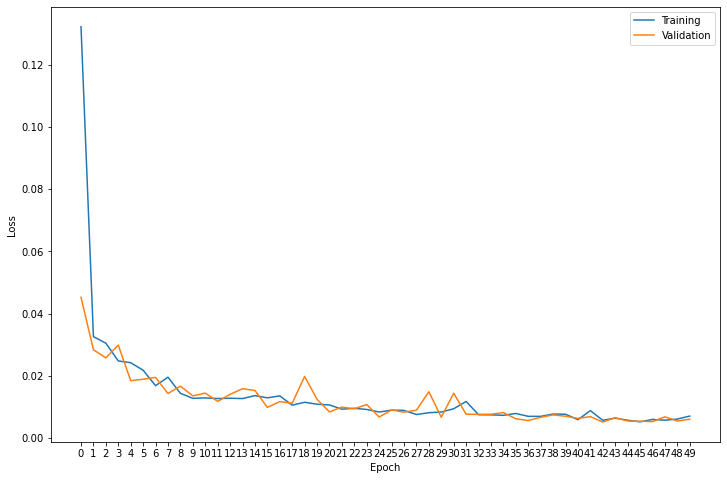

  0%|          | 0/100 [00:00<?, ?it/s]


Finished Training, Testing on test set


  0%|          | 0/100 [00:00<?, ?it/s]


 0.00679695403602409

Generating Unlabeled Result
torch.Size([1, 3, 256, 512])


  0%|          | 0/100 [00:00<?, ?it/s]


AssertionError: 

In [9]:
%%time
# Set up the random seed for reproducibility, you should not modify the seed used here
torch.manual_seed(442)
random.seed(442)
np.random.seed(442)

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
#criterion = DiceLoss()

# Define the dataset and dataloder
print("HEre")
train_data = DeepScoresDataset("train")
print("HEre")
val_data = DeepScoresDataset("validation")
print("HEre")
test_data = DeepScoresDataset("test")
print("HEre")

train_loader = DataLoader(train_data, batch_size=2)
val_loader = DataLoader(val_data, batch_size=2)

test_loader = DataLoader(test_data, batch_size=1)

# ap_loader for calculating Average Precision
ap_data = DeepScoresDataset("test", one_hot=True)
ap_loader = DataLoader(ap_data, batch_size=1)

learning_rate = 0.001
weight_decay = 0#1e-5
num_epoch = 50  # TODO: Choose an appropriate number of training epochs
optimizer = optim.Adam(net.parameters(), lr=learning_rate,
                       weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

print('\nStart training')
trn_hist = []
val_hist = []
net.train()
for epoch in range(num_epoch): #TODO: Change the number of epochs
    print('-----------------Epoch = %d-----------------' % (epoch+1))
    trn_loss = train(train_loader, net, criterion, optimizer, device, epoch+1)
    print('Validation loss: ')
    val_loss = test(val_loader, net, criterion, device)
    trn_hist.append(trn_loss)
    val_hist.append(val_loss)

net.eval()
plot_hist(trn_hist, val_hist)

print('\nFinished Training, Testing on test set')
test(test_loader, net, criterion, device)
print('\nGenerating Unlabeled Result')

result = get_result(test_loader, net, device, folder='output_test')

os.makedirs('./models', exist_ok=True)
torch.save(net.state_dict(), './models/model_skiplink_{}.pth'.format(name))
print("Here")
cal_AP(ap_loader, net, criterion, device)

image: 8


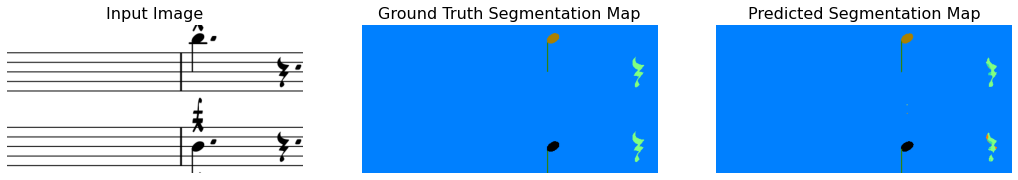

In [34]:
img_idx = 8

print(f'image: {img_idx}')
output_dir = 'output_test'

plt.subplot(1, 3, 1)
plt.imshow(Image.open(os.path.join(output_dir, 'x{}.png'.format(img_idx))))
plt.title('Input Image', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(Image.open(os.path.join(output_dir, 'gt{}.png'.format(img_idx))))
plt.title('Ground Truth Segmentation Map', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(Image.open(os.path.join(output_dir, 'y{}.png'.format(img_idx))))
plt.title('Predicted Segmentation Map', fontsize=16)
plt.axis('off')

plt.gcf().set_size_inches(18, 10)
plt.show()

# Full Page Combiner

(2772, 1960, 3)
0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3
4 0
4 1
4 2
4 3
5 0
5 1
5 2
5 3
6 0
6 1
6 2
6 3
7 0
7 1
7 2
7 3
8 0
8 1
8 2
8 3
9 0
9 1
9 2
9 3
10 0
10 1
10 2
10 3
Finished Making All the Images!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


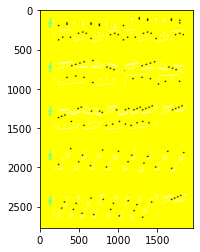

In [10]:
import math
import cv2

## Load the NET
net = Net().to(device)
net.load_state_dict(torch.load("./models/model_april_23.pth"))
net.eval()

# Get Image with some padding
img_name = 'test_orig.png'
img = np.array(Image.open(img_name))
#img = cv2.resize(img, dsize=(img.shape[1]*2, img.shape[0]*2))

#img = np.stack((img,)*3, axis=-1)
print(img.shape)
#img = np.array([img, img, img])
cv2.imwrite(os.path.join('output', img_name), img)
H, W, _ = img.shape

img_w_padding = array_created = np.full((H + 256, W+512, 3), 255, dtype = np.uint8)
img_w_padding[0:H, 0:W] = img
img = img_w_padding

segmented_img = np.zeros(img.shape)
img = torch.FloatTensor(img).permute(2, 0, 1)


##### Segment the image a bunch of times
for row in range(math.ceil(H/256)):
    for col in range(math.ceil(W/512)):
        print(row, col)
        i = row * 256
        j = col*512
        h = 256
        w = 512
        

        cropped_img = transforms.functional.crop(img, i, j, h, w)
        cropped_img = cropped_img.unsqueeze(0)

        folder = "output"

        os.makedirs(folder, exist_ok=True)
        with torch.no_grad():
            output = net(cropped_img)[0].cpu().numpy()
            c, h, w = output.shape
            assert(c == N_CLASS)
            y = np.argmax(output, 0).astype('uint8')
            save_label(y, './{}/{},{}.png'.format(folder, row, col))
print("Finished Making All the Images!")

##### Put the images back together
for row in range(math.ceil(H/256)):
    for col in range(math.ceil(W/512)):
        f_name = str(row) + "," + str(col) + ".png"
        segmented_segment = cv2.imread(os.path.join('output', f_name), cv2.IMREAD_COLOR)
        i = row * 256
        j = col*512
        segmented_img[i:i+256, j:j+512] = segmented_segment

segmented_img = segmented_img[0:H, 0:W]
cv2.imwrite('output/final.png', segmented_img)
plt.imshow(segmented_img)
plt.show()

In [16]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def get_width_height(rect, h, w):

    for i in range(0, 4, 1):
        if rect[i][0] < 0:
            rect[i][0] = 0;
        if rect[i][1] < 0:
            rect[i][1] = 0;
        if rect[i][0] > w -1:
            rect[i][0] = w -1
        if rect[i][1] > h -1:
            rect[i][1] = h -1


    furthest_top = rect[0][1]
    if (rect[1][1] < furthest_top):
        furthest_top = rect[1][1]

    furthest_bot = rect[2][1]
    if (rect[3][1] > furthest_bot):
        furthest_bot = rect[3][1]

    furthest_right = rect[1][0]
    if (rect[2][0] > furthest_right):
        furthest_right = rect[2][0]

    furthest_left = rect[0][0]
    if (rect[3][0] < furthest_left):
        furthest_left = rect[3][0]

    height = furthest_bot - furthest_top
    width = furthest_right - furthest_left


    return (int(furthest_left), int(furthest_top), int(width), int(height))

In [20]:
import imutils
frame = cv2.imread('output/final.png')
height, width = frame.shape[:2]

line_note_mask = cv2.inRange(frame, (0,0,0), (0, 0, 0))
gap_note_mask = cv2.inRange(frame, (255, 255, 255), (255, 255, 255))


filters = [("line_note", np.array([0, 0, 0]), np.array([0, 0, 0])), \
            ("gap_note", np.array([255, 255, 255]), np.array([255, 255, 255]))]

boxes = {}

for name, lower_bound, upper_bound in filters:
    mask = cv2.inRange(frame, lower_bound, upper_bound)
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    
    if len(cnts)>0:
        curr_boxes = []
        for (i, c) in enumerate(cnts):
            box = cv2.minAreaRect(c)
            box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
            box = np.array(box, dtype="int")
            cv2.drawContours(frame, [box], -1, (0, 255, 0), 2)
            
            rect = order_points(box)
            colors = ((0, 0, 255), (240, 0, 159), (255, 0, 0), (255, 255, 0))
            
            # Get properly oriented bounding box
            x, y, w, h = get_width_height(rect, height, width)
            curr_boxes.append((x, y, w, h))

            cv2.putText(frame, "{}".format(i + 1),
                (int(rect[0][0] - 15), int(rect[0][1] - 15)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.55, (200, 200, 200), 1)
        
        cv2.imwrite('output/annotted.png', frame)
        boxes[name] = curr_boxes
print(boxes)

    

{'line_note': [(1297, 2626, 20, 17), (999, 2609, 20, 17), (682, 2588, 3, 26), (525, 2576, 19, 17), (1039, 2559, 0, 0), (1187, 2543, 20, 16), (886, 2523, 26, 24), (415, 2527, 20, 17), (262, 2506, 26, 24), (1222, 2465, 20, 17), (924, 2449, 20, 17), (446, 2444, 15, 27), (1407, 2429, 26, 23), (301, 2432, 20, 17), (1109, 2411, 27, 26), (1666, 2399, 20, 17), (791, 2396, 26, 24), (1246, 2390, 1, 1), (473, 2390, 1, 0), (1703, 2383, 20, 17), (638, 2383, 20, 17), (1750, 2361, 15, 26), (1778, 2345, 15, 26), (1665, 2004, 20, 17), (1463, 1987, 19, 17), (831, 1984, 27, 23), (640, 1966, 15, 26), (223, 1961, 26, 15), (1321, 1933, 3, 26), (1107, 1917, 26, 24), (479, 1917, 26, 24), (1361, 1853, 20, 17), (1158, 1837, 20, 17), (531, 1837, 19, 17), (1816, 1799, 15, 26), (1617, 1788, 19, 16), (989, 1788, 20, 16), (786, 1771, 20, 16), (381, 1754, 19, 17), (1149, 1458, 20, 17), (834, 1458, 19, 17), (551, 1458, 20, 17), (1077, 1442, 20, 17), (914, 1442, 20, 17), (1377, 1425, 20, 17), (1225, 1425, 20, 17), (129